In [2]:
import numpy as np
import pandas as pd

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns',50)

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api

plt.rcParams['figure.figsize'] = [12, 6]

from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score,roc_auc_score,f1_score,roc_curve,precision_score

In [3]:
df=pd.read_csv('Cleaned_Data.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default,Higest_Delay,Delay_Count,age_group,billmean,amtmean
0,20000,0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,2,2,0,1284.000000,114.833333
1,120000,0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,2,5,0,2846.166667,833.333333
2,90000,0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,6,1,16942.166667,1836.333333
3,50000,0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,6,1,38555.666667,1398.000000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,4,2,18223.166667,9841.500000


In [ ]:
## Train-Test Split

In [4]:
X=df.drop('Default',1)
y=df['Default']
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=10,test_size=0.25)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(22500, 28)
(7500, 28)
(22500,)
(7500,)


In [5]:
#Power Transform the data
PT=PowerTransformer()
xtrain_en=PT.fit_transform(xtrain)
xtest_en=PT.transform(xtest)

xtrain=pd.DataFrame(xtrain_en,columns=xtrain.columns)
xtest=pd.DataFrame(xtest_en,columns=xtest.columns)



In [85]:
score_df=pd.DataFrame(columns=['Name','Acc','f1-score','roc-auc'])
model_=dict()
def update(Model_name,model,xtr,xts,ytr=ytrain,yts=ytest):
    model.fit(xtr,ytr)
    y_pred=model.predict(xts)
    y_pred_prob=model.predict_proba(xts)[:,1]
    acc=accuracy_score(yts,y_pred)
    f1=f1_score(yts,y_pred)
    roc=roc_auc_score(yts,y_pred_prob)
    
    global score_df
    
    global model_
    score_df=score_df.append({'Name':Model_name,"Acc":acc,"f1-score":f1,'roc-auc':roc},ignore_index=True)
    
    report=classification_report(yts,y_pred)
    print(report)
    
    model_[Model_name]=model
    return score_df

    
    

In [ ]:
# Random Forest

In [41]:

param_ = {'n_estimators':np.arange(30,200,30)}
rf_grid=GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_,cv=3,scoring='f1')

rf_grid.fit(xtrain,ytrain)
rf_grid.best_params_

{'n_estimators': 90}

In [86]:
models_=list()
rf_best=RandomForestClassifier(n_estimators=90)
update('Random_Forest',rf_best,xtrain,xtest)


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5830
           1       0.65      0.36      0.47      1670

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.68      7500
weighted avg       0.80      0.82      0.79      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.8152,0.466923,0.761342


In [56]:
param_ = {'learning_rate':np.arange(0.5,1,0.05)}
ab_grid=GridSearchCV(estimator=AdaBoostClassifier(random_state=10),param_grid=param_,cv=3,scoring='f1')

ab_grid.fit(xtrain,ytrain)
ab_grid.best_params_

{'learning_rate': 0.8000000000000003}

In [87]:
ab_best=AdaBoostClassifier(learning_rate=0.8,random_state=10)
update('Adaboost',ab_best,xtrain,xtest)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5830
           1       0.70      0.33      0.45      1670

    accuracy                           0.82      7500
   macro avg       0.77      0.65      0.67      7500
weighted avg       0.80      0.82      0.79      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.8152,0.466923,0.761342
1,Adaboost,0.8200,0.449429,0.780157


In [62]:
param_ = {'learning_rate':np.arange(0.5,1,0.05)}
gb_grid=GridSearchCV(estimator=GradientBoostingClassifier(random_state=10),param_grid=param_,cv=3,scoring='f1')

gb_grid.fit(xtrain,ytrain)
gb_grid.best_params_

{'learning_rate': 0.55}

In [88]:
gb_best=GradientBoostingClassifier(learning_rate=0.55,random_state=10)
update('GradientBoost',gb_best,xtrain,xtest)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5830
           1       0.63      0.37      0.46      1670

    accuracy                           0.81      7500
   macro avg       0.73      0.65      0.67      7500
weighted avg       0.79      0.81      0.79      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.8152,0.466923,0.761342
1,Adaboost,0.8200,0.449429,0.780157
2,GradientBoost,0.8112,0.464448,0.770851


In [16]:
# As we can see there is improvement over recall value

In [19]:
import lightgbm 
from lightgbm import LGBMClassifier

In [89]:
#Lets fit a simple LGBM model
lgb_basic=LGBMClassifier(random_state=10)
update('LGBM_Basic',lgb_basic,xtrain,xtest)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5830
           1       0.70      0.37      0.49      1670

    accuracy                           0.82      7500
   macro avg       0.77      0.66      0.69      7500
weighted avg       0.81      0.82      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.8152,0.466923,0.761342
1,Adaboost,0.8200,0.449429,0.780157
2,GradientBoost,0.8112,0.464448,0.770851
3,LGBM_Basic,0.8248,0.485915,0.782189


In [34]:
#Though accuracy has increased giving an increases in recall value
#Lets perform a smote as recall value for minority class is saturated at 0.37

(28, 22500)

In [46]:
from imblearn.over_sampling import SMOTE
os=SMOTE(random_state=10)
xtrain_os,ytrain_os=os.fit_resample(xtrain,ytrain)

xtrain_os.shape,ytrain_os.shape

((35068, 28), (35068,))

In [90]:
lgb_smote_basic=LGBMClassifier(random_state=10)
update('LGBM_Smote_Basic',lgb_smote_basic,xtrain_os,xtest,ytrain_os,ytest)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5830
           1       0.63      0.41      0.50      1670

    accuracy                           0.82      7500
   macro avg       0.74      0.67      0.69      7500
weighted avg       0.80      0.82      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.8152,0.466923,0.761342
1,Adaboost,0.8200,0.449429,0.780157
2,GradientBoost,0.8112,0.464448,0.770851
3,LGBM_Basic,0.8248,0.485915,0.782189
4,LGBM_Smote_Basic,0.8164,0.500906,0.779660


In [ ]:
#It increases the recall value with the cost of precision.
#Lets try different techinique of smote with hyperparameter tuning

In [19]:

param=[{'learning_rate':np.arange(0.1,0.22,0.02),
        'n_estimators':np.arange(50,200,50),'reg_alpha':np.arange(4,7,1),
       'reg_lambda':np.arange(50,61,5),'max_depth':[10,11,12]}]



lgb_smote_grid=GridSearchCV(estimator=LGBMClassifier(random_state=10),param_grid=param,cv=3,scoring='recall',n_jobs=-1)

lgb_smote_grid.fit(xtrain_os,ytrain_os)

lgb_smote_grid.best_params_

{'learning_rate': 0.14,
 'max_depth': 11,
 'n_estimators': 100,
 'reg_alpha': 4,
 'reg_lambda': 55}

In [91]:
lgb=LGBMClassifier(boosting_type='gbdt',learning_rate=0.14,n_estimators=100,reg_alpha=4,
                   reg_lambda=55,max_depth=11,random_state=10)
update('LGBM_smote_gbdt',lgb,xtrain_os,xtest,ytrain_os,ytest)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5830
           1       0.61      0.42      0.50      1670

    accuracy                           0.81      7500
   macro avg       0.73      0.67      0.69      7500
weighted avg       0.79      0.81      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.815200,0.466923,0.761342
1,Adaboost,0.820000,0.449429,0.780157
2,GradientBoost,0.811200,0.464448,0.770851
3,LGBM_Basic,0.824800,0.485915,0.782189
4,LGBM_Smote_Basic,0.816400,0.500906,0.779660
5,LGBM_smote_gbdt,0.810133,0.497530,0.775639


In [92]:
lgb=LGBMClassifier(boosting_type='goss',learning_rate=0.14,n_estimators=100,reg_alpha=4,
                   reg_lambda=55,max_depth=11,random_state=10)
update('LGBM_smote_goss',lgb,xtrain_os,xtest,ytrain_os,ytest)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5830
           1       0.58      0.45      0.51      1670

    accuracy                           0.81      7500
   macro avg       0.72      0.68      0.69      7500
weighted avg       0.79      0.81      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.815200,0.466923,0.761342
1,Adaboost,0.820000,0.449429,0.780157
2,GradientBoost,0.811200,0.464448,0.770851
3,LGBM_Basic,0.824800,0.485915,0.782189
4,LGBM_Smote_Basic,0.816400,0.500906,0.779660
5,LGBM_smote_gbdt,0.810133,0.497530,0.775639
6,LGBM_smote_goss,0.805200,0.509567,0.768722


In [93]:
lgb_smote_dart=LGBMClassifier(boosting_type='dart',learning_rate=0.14,n_estimators=100,reg_alpha=4,
                   reg_lambda=55,max_depth=11,random_state=10)
update('LGBM_smote_dart',lgb_smote_dart,xtrain_os,xtest,ytrain_os,ytest)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5830
           1       0.56      0.50      0.53      1670

    accuracy                           0.80      7500
   macro avg       0.71      0.69      0.70      7500
weighted avg       0.79      0.80      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.815200,0.466923,0.761342
1,Adaboost,0.820000,0.449429,0.780157
2,GradientBoost,0.811200,0.464448,0.770851
3,LGBM_Basic,0.824800,0.485915,0.782189
4,LGBM_Smote_Basic,0.816400,0.500906,0.779660
5,LGBM_smote_gbdt,0.810133,0.497530,0.775639
6,LGBM_smote_goss,0.805200,0.509567,0.768722
7,LGBM_smote_dart,0.800933,0.529764,0.781955


In [29]:
## Dart algorithm is giving best recall as well as best f1_score.
#Lets try different smote technique

In [ ]:
#ADASYN over_sampling

In [53]:
from imblearn.over_sampling import ADASYN
ad=ADASYN(random_state=10)

xtrain_ad,ytrain_ad=ad.fit_resample(xtrain,ytrain)
ytrain.value_counts(),ytrain_ad.value_counts()

(0    17534
 1     4966
 Name: Default, dtype: int64,
 0    17534
 1    17145
 Name: Default, dtype: int64)

In [31]:
param=[{'learning_rate':np.arange(0.18,0.29,0.02),
        'n_estimators':np.arange(50,200,50),'reg_alpha':np.arange(8,12,1),
       'reg_lambda':np.arange(45,56,5),'max_depth':[7,8,9]}]



lgb_ada_grid=GridSearchCV(estimator=LGBMClassifier(boosting_type='dart',random_state=10),param_grid=param,cv=3,
                          scoring='recall',n_jobs=-1)

lgb_ada_grid.fit(xtrain_ad,ytrain_ad)

lgb_ada_grid.best_params_

{'learning_rate': 0.2799999999999999,
 'max_depth': 8,
 'n_estimators': 100,
 'reg_alpha': 8,
 'reg_lambda': 45}

In [94]:
lgb_adasyn=LGBMClassifier(boosting_type='dart',learning_rate=0.27,n_estimators=100,reg_alpha=8,
                   reg_lambda=45,max_depth=8,random_state=10)
update('LGBM_adasyn_dart',lgb_adasyn,xtrain_ad,xtest,ytrain_ad,ytest)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5830
           1       0.60      0.45      0.52      1670

    accuracy                           0.81      7500
   macro avg       0.73      0.68      0.70      7500
weighted avg       0.80      0.81      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.815200,0.466923,0.761342
1,Adaboost,0.820000,0.449429,0.780157
2,GradientBoost,0.811200,0.464448,0.770851
3,LGBM_Basic,0.824800,0.485915,0.782189
4,LGBM_Smote_Basic,0.816400,0.500906,0.779660
5,LGBM_smote_gbdt,0.810133,0.497530,0.775639
6,LGBM_smote_goss,0.805200,0.509567,0.768722
7,LGBM_smote_dart,0.800933,0.529764,0.781955
8,LGBM_adasyn_dart,0.810400,0.515997,0.772908


In [ ]:
#Decrease in recall and alpha value.

In [ ]:
# Lets use oversampling and undersampling together.

In [56]:
from imblearn.combine import SMOTETomek
smtk=SMOTETomek(random_state=10)

xtrain_tk,ytrain_tk=smtk.fit_resample(xtrain,ytrain)
ytrain.value_counts(),ytrain_tk.value_counts()

(0    17534
 1     4966
 Name: Default, dtype: int64,
 0    17297
 1    17297
 Name: Default, dtype: int64)

In [41]:
param=[{'learning_rate':np.arange(0.21,0.32,0.02),
        'n_estimators':np.arange(50,200,50),'reg_alpha':np.arange(8,12,1),
       'reg_lambda':np.arange(85,101,5),'max_depth':[6,7,8]}]



lgb_tk_grid=GridSearchCV(estimator=LGBMClassifier(boosting_type='dart',random_state=10),param_grid=param,cv=3,
                          scoring='recall',n_jobs=-1)

lgb_tk_grid.fit(xtrain_tk,ytrain_tk)

lgb_tk_grid.best_params_

{'learning_rate': 0.30999999999999994,
 'max_depth': 8,
 'n_estimators': 100,
 'reg_alpha': 8,
 'reg_lambda': 95}

In [95]:
lgb_tomek=LGBMClassifier(boosting_type='dart',learning_rate=0.31,n_estimators=100,reg_alpha=8,
                   reg_lambda=95,max_depth=8,random_state=10)
update('LGBM_smote+tomek_dart',lgb_tomek,xtrain_tk,xtest,ytrain_tk,ytest)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      5830
           1       0.57      0.48      0.52      1670

    accuracy                           0.80      7500
   macro avg       0.72      0.69      0.70      7500
weighted avg       0.79      0.80      0.80      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.815200,0.466923,0.761342
1,Adaboost,0.820000,0.449429,0.780157
2,GradientBoost,0.811200,0.464448,0.770851
3,LGBM_Basic,0.824800,0.485915,0.782189
4,LGBM_Smote_Basic,0.816400,0.500906,0.779660
5,LGBM_smote_gbdt,0.810133,0.497530,0.775639
6,LGBM_smote_goss,0.805200,0.509567,0.768722
7,LGBM_smote_dart,0.800933,0.529764,0.781955
8,LGBM_adasyn_dart,0.810400,0.515997,0.772908
9,LGBM_smote+tomek_dart,0.804667,0.521085,0.778726


In [33]:
#Smote+enn

In [59]:
from imblearn.combine import SMOTEENN
osenn=SMOTEENN(random_state=10)

xtrain_enn,ytrain_enn=osenn.fit_resample(xtrain,ytrain)

ytrain.value_counts(),ytrain_enn.value_counts()

(0    17534
 1     4966
 Name: Default, dtype: int64,
 1    14214
 0     9252
 Name: Default, dtype: int64)

In [35]:
param=[{'learning_rate':np.arange(0.18,0.29,0.02),
        'n_estimators':np.arange(50,200,50),'reg_alpha':np.arange(8,12,1),
       'reg_lambda':np.arange(55,66,5),'max_depth':[10,11,12]}]



lgb_smote_grid=GridSearchCV(estimator=LGBMClassifier(boosting_type='dart',random_state=10),param_grid=param,
                            cv=3,scoring='recall',n_jobs=-1)

lgb_smote_grid.fit(xtrain_enn,ytrain_enn)

lgb_smote_grid.best_params_

{'learning_rate': 0.2799999999999999,
 'max_depth': 11,
 'n_estimators': 150,
 'reg_alpha': 9,
 'reg_lambda': 55}

In [96]:
lgb=LGBMClassifier(boosting_type='dart',learning_rate=0.27,n_estimators=150,reg_alpha=9,
                   reg_lambda=55,max_depth=11,random_state=10)
update('LGBM_smote+enn_dart',lgb,xtrain_enn,xtest,ytrain_enn,ytest)

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      5830
           1       0.44      0.67      0.53      1670

    accuracy                           0.74      7500
   macro avg       0.67      0.71      0.68      7500
weighted avg       0.79      0.74      0.75      7500



,Name,Acc,f1-score,roc-auc
0,Random_Forest,0.815200,0.466923,0.761342
1,Adaboost,0.820000,0.449429,0.780157
2,GradientBoost,0.811200,0.464448,0.770851
3,LGBM_Basic,0.824800,0.485915,0.782189
4,LGBM_Smote_Basic,0.816400,0.500906,0.779660
5,LGBM_smote_gbdt,0.810133,0.497530,0.775639
6,LGBM_smote_goss,0.805200,0.509567,0.768722
7,LGBM_smote_dart,0.800933,0.529764,0.781955
8,LGBM_adasyn_dart,0.810400,0.515997,0.772908
9,LGBM_smote+tomek_dart,0.804667,0.521085,0.778726


In [43]:
#Lets choose this as our final model.

In [61]:
lgb_final=LGBMClassifier(boosting_type='dart',learning_rate=0.27,n_estimators=150,reg_alpha=9,
                   reg_lambda=55,max_depth=11,random_state=10)

lgb_final.fit(xtrain_enn,ytrain_enn)


y_pred=lgb_final.predict(xtest)
report=classification_report(ytest,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      5830
           1       0.44      0.67      0.53      1670

    accuracy                           0.74      7500
   macro avg       0.67      0.71      0.68      7500
weighted avg       0.79      0.74      0.75      7500



In [62]:
models_.append(lgb_final)

In [47]:
cm=confusion_matrix(ytest,y_pred)
print(cm)

[[4463 1367]
 [ 566 1104]]


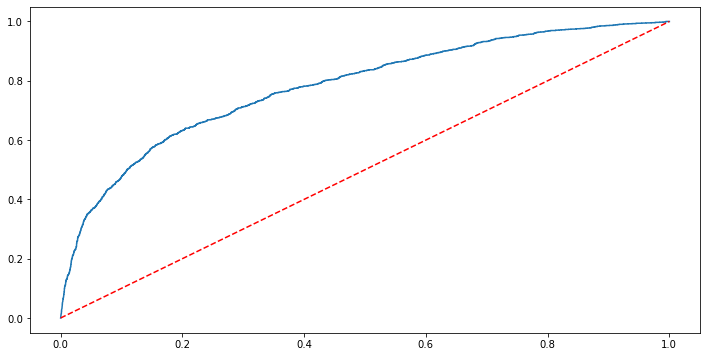

In [53]:
y_pred_prob=lgb_final.predict_proba(xtest)[:,1]
fpr,tpr,th=roc_curve(ytest,y_pred_prob)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')

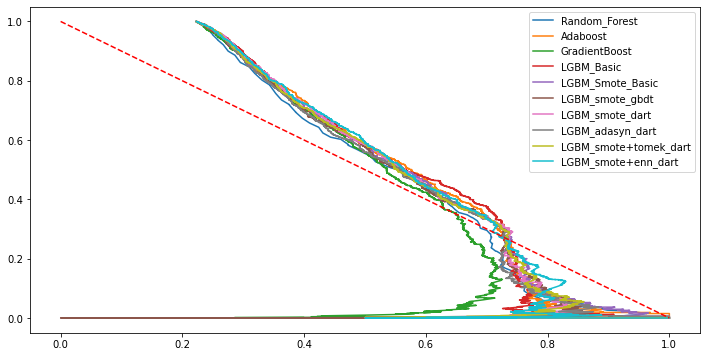

In [84]:

from sklearn.metrics import precision_recall_curve

for model_n,model in model_.items():
    y_pred_prob=model.predict_proba(xtest)[:,1]

    pr,re,th=precision_recall_curve(ytest,y_pred_prob)

    plt.plot(pr,re,label=model_n)
    
    
plt.legend()
plt.plot([0,1],[1,0],'r--')